<a href="https://colab.research.google.com/github/deshanchathusanka/machine-learning-algorithms/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/tstLabel_fine.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/tstLabel_coarse.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/tstImage.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/trnLabel_fine.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/trnLabel_coarse.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/trnImage.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/fine_labels.csv" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/coarse_labels.csv" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/x_train.npy" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM45J - Big Data & Machine Learning/coursework/x_test.npy" "/content/"

Mounted at /content/drive


**Import Statements**

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

**Review Dataset and Labels**

Number of Fine Labels(Class) : (100,)
Number of Coarse Labels(Super Class) : (20,)

Shape of Original Images : (32, 32, 3, 50000)
Shape of Fine Labels : (50000,)
Shape of Coarse Labels : (50000,)



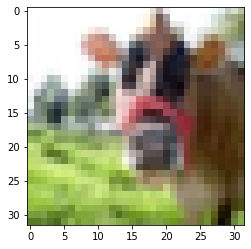

Fine Label : cattle
Coarse Label : large omnivores and herbivores


In [11]:
images = np.load('./trnImage.npy')
images_test = np.load('./tstImage.npy')

label_fine = np.load('./trnLabel_fine.npy')
label_coarse = np.load('./trnLabel_coarse.npy')
label_fine_test = np.load('./tstLabel_fine.npy')
label_coarse_test = np.load('./tstLabel_coarse.npy')
label_fine_names = pd.read_csv("fine_labels.csv", header=None, delimiter=',').iloc[0]
label_coarse_names = pd.read_csv("coarse_labels.csv", header=None, delimiter=',').iloc[0]

############## shapes of dataset ###################
print(f'Number of Fine Labels(Class) : {label_fine_names.shape}')
print(f'Number of Coarse Labels(Super Class) : {label_coarse_names.shape}\n')
print(f'Shape of Original Images : {images.shape}') # (Height, Width, Channel, Samples)
print(f'Shape of Fine Labels : {label_fine.shape}')
print(f'Shape of Coarse Labels : {label_coarse.shape}\n')

############# understand dataset content ###############
img_index = 0
image = images[:,:,:,img_index]
plt.figure()
plt.imshow(image)
plt.show()
label_fine_name = label_fine_names[label_fine[img_index]]
label_course_name = label_coarse_names[label_coarse[img_index]]
print(f'Fine Label : {label_fine_name}')
print(f'Coarse Label : {label_course_name}')

**Manual Feature Extraction Using HOG (Histogram of Oriented Gradient)**

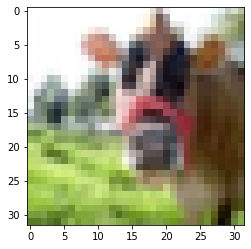

Number of Hog Feature : (576,)


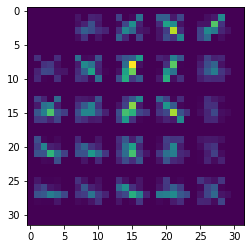

In [5]:
NO_TRAIN_SAMPLE = 50000
NO_TEST_SAMPLE = 10000
NO_OF_FEATURE = 576

########################### manually extract features of images and store in a file ###############################
image = images[:, :, :, 0]
plt.figure()
plt.imshow(image)
plt.show()
hog_feature, hog_image = skimage.feature.hog(image, pixels_per_cell=[6,6], cells_per_block=[2,2], visualize=True)
print(f'Number of Hog Feature : {hog_feature.shape}')
plt.figure()
plt.imshow(hog_image)
plt.show()

# x_train = np.empty(shape = (NO_TRAIN_SAMPLE, NO_OF_FEATURE))
# for index in range(0, NO_TRAIN_SAMPLE): # Training images
#   image = images[:, :, :, index]
#   hog_feature = skimage.feature.hog(image, pixels_per_cell=[6,6], cells_per_block=[2,2], visualize=False)
#   x_train[index] = hog_feature
# np.save(file = 'x_train.py', arr = x_train)

# x_test = np.empty(shape = (NO_TEST_SAMPLE, NO_OF_FEATURE))
# for index in range(0, NO_TEST_SAMPLE): # Testing images
#   image = images_test[:, :, :, index]
#   hog_feature = skimage.feature.hog(image, pixels_per_cell=[6,6], cells_per_block=[2,2], visualize=False)
#   x_test[index] = hog_feature
# np.save(file = 'x_test.py', arr = x_test)


In [6]:
############### load feature extracted training and testing dataset ##############
x_train = np.load('./x_train.npy')
x_test = np.load('./x_test.npy')
y_train = label_fine
y_test = label_fine_test
print(f'Shape of X_Train : {x_train.shape}')
print(f'Shape of X_Test : {x_test.shape}')

###############Data standardization #################
scaler = StandardScaler()
# Calculate mean and variance of each feature for further pre-processing
scaler.fit(X = x_train, y = y_train) 
print(f'Shape of mean of dataset : {scaler.mean_.shape}') # (13,)
# Standardize data (Centering and Scaling)
x_train_standard = scaler.transform(X = x_train)
x_test_standard = scaler.transform(X = x_test)


Shape of X_Train : (50000, 576)
Shape of X_Test : (10000, 576)
Shape of mean of dataset : (576,)


**Support Vector Machine**


* Features = HoG(Image) = 576

* Input = (50000, 576) = (Samples, Features)

* Output = (50000, 1)

In [7]:
""" Train Support Vector Machine Classifier """

cross_validation_c = {}
for c in range(1,2) :
  svc = SVC(C = c, kernel = 'rbf') # Kernel = Radial Basis Function Kernel(Gaussian Kernel)
  # Train the model using training data
  svc.fit(X = x_train_standard, y = y_train) 
  # Predict labels from trained model
  y_hat = svc.predict(X = x_test_standard)
  # Calculate accuracy
  accuracy = svc.score(X = x_test_standard, y = y_test)
  cross_validation_c[c] = accuracy

print(cross_validation_c)

{1: 0.283}


**Convolution Neural Network (CNN)**

Input = (50000, 32, 32, 3) = (Samples, Height, Width, Channel)


In [13]:
################### Dimension of X = (S, H, W, C) = (Samples, Height, Width, Channel) ########################
x_cnn_train = np.transpose(a = images, axes = (3,0,1,2))
x_cnn_test = np.transpose(a = images_test, axes = (3,0,1,2))
print(x_cnn_train.shape)
print(x_cnn_test.shape)

####################### Normalize Pixel Values ############################
max_pixel_value = np.max(x_cnn_train)
x_cnn_train_norm = x_cnn_train/max_pixel_value
x_cnn_test_norm = x_cnn_test/max_pixel_value

################### Define Image Sizes ##############################
Image_Width = 32 # pixel width of image.
Image_Height = 32 # pixel height of image.
Image_Size = (Image_Width, Image_Height) # resolution of image.
Image_Channels=3 # number of colour channels in images.

################# Define CNN Architecture : 2D CNN Layers ###################
model = Sequential()

######## Feature Extraction Layers = Convolutional-Subsampling Pairs (Increase number of feature maps for each subsequent pairs) #########
"""
1st hiden layer
shape(input) = shape(output)
kernal = (5,5)
Number of filters = 24
"""
model.add(Conv2D(filters=24,kernel_size=5,strides=1,padding='same',activation='relu', input_shape=(Image_Width,Image_Height,Image_Channels))) 
model.add(MaxPooling2D(pool_size=(2,2)))

"""
2nd hiden layer
shape(input) = shape(output)
kernal = (5,5)
Number of filters = 48
"""
model.add(Conv2D(filters=48,kernel_size=5,strides=1,padding='same',activation='relu')) # 2nd hiden layer
model.add(MaxPooling2D(pool_size=(2,2)))

"""
output layer
shape(input) = shape(output)
kernal = (5,5)
Number of filters = 96
"""
model.add(Conv2D(filters=96,kernel_size=5,strides=1,padding='same',activation='relu')) # output layer
model.add(MaxPooling2D(pool_size=(2,2)))

############### Classification Layers = Dense Layers ########################
""" 3D Image(Width, Height, Filters) = (4, 4, 96) >> 1D = (1536, 1)"""
model.add(Flatten()) 

"""
Input = (1536, 1)
Output = (256, 1)
"""
model.add(Dense(256,activation=tf.nn.relu))

"""
Input = (256, 1)
Output = (10, 1)
"""
model.add(Dense(10,activation=tf.nn.softmax))

# model.compile(optimizer=tf.keras.optimizers.SGD(), # Strochastic Gradient Descent
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Cross Entrophy Function
#               metrics=tf.keras.metrics.SparseCategoricalAccuracy()) # Consider Model Accuracy


# """ Train The Model """
# history = model.fit(x_train_mnist_cnn_norm, y_train_mnist, epochs=5, validation_split=0.2, verbose=1)

# """ Print The Summary """
# model.summary()

# """  Plot Accuracy And Loss Curves """
# plt.figure(figsize=[10,5])
# plt.subplot(121)
# plt.plot(history.history['sparse_categorical_accuracy'])
# plt.plot(history.history['val_sparse_categorical_accuracy'])
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['Training Accuracy',
#            'Validation Accuracy'])
# plt.title('Accuracy Curves')

# plt.subplot(122)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Training Loss',
#            'Validation Loss'])
# plt.title('Loss Curves')
# plt.show()

# # Predict labels from trained model
# y_hat = model.predict(x_test_mnist_cnn_norm)

# """ Evaluate With Test Datatset """
# results = model.evaluate(x_test_mnist_cnn_norm, y_test_mnist)
# print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

# """ Analyse Training Cureves """
# print(y_test_mnist)
# print(np.argmax(y_hat, axis=1))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
